In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from src.maze import MazeEnv
from tensorboardX import SummaryWriter
import os
import numpy as np
import random
from collections import namedtuple

In [133]:
class Perception(nn.Module):
    def __init__(self, shape: tuple[int, int], action_space: int = 4) -> None:
        super().__init__()
        w, h = shape
        k, p, s = 2, 1, 2
        self.cn1 = nn.Conv2d(1, 8, k, s, p)  # 2
        self.cn2 = nn.Conv2d(8, 32, k, s, p)  # 4

        w, h = (w - k + 2 * p) // s + 1, (h - k + 2 * p) // s + 1
        w, h = (w - k + 2 * p) // s + 1, (h - k + 2 * p) // s + 1
        self.fc1 = nn.Linear(32 * w * h, action_space * 16)

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.cn1(img))
        x = F.relu(self.cn2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return x


In [134]:
class Manager(nn.Module):
    def __init__(self, dilation, num_actions, device):
        super(Manager, self).__init__()

        hidden_size = num_actions * 16

        self.hx_memory = [torch.zeros(1, num_actions * 16).to(device) for _ in range(dilation)]

        self.cx_memory = [torch.zeros(1, num_actions * 16).to(device) for _ in range(dilation)]
        self.hidden_size = hidden_size
        self.horizon = dilation
        self.index = 0

        self.fc = nn.Linear(num_actions * 16, num_actions * 16)
        # todo: change lstm to dilated lstm
        self.lstm = nn.LSTMCell(num_actions * 16, hidden_size=num_actions * 16)
        # todo: add lstm initialization
        self.lstm.bias_ih.data.fill_(0)
        self.lstm.bias_hh.data.fill_(0)

        self.fc_critic1 = nn.Linear(num_actions * 16, 50)
        self.fc_critic2 = nn.Linear(50, 1)

        self.fc_actor = nn.Linear(50, num_actions)

    def forward(self, inputs):
        x, (hx, cx) = inputs
        x = F.relu(self.fc(x))
        state = x

        hx_t_1 = self.hx_memory[self.index]
        cx_t_1 = self.cx_memory[self.index]
        self.hx_memory[self.index] = hx
        self.cx_memory[self.index] = cx

        hx, cx = self.lstm(x, (hx_t_1, cx_t_1))
        self.index += 1
        if self.index >= self.horizon:
            self.index %= self.horizon

        goal = cx
        value = F.relu(self.fc_critic1(goal))
        value = self.fc_critic2(value)
        
        goal_norm = torch.norm(goal, p=2, dim=1).unsqueeze(1)
        goal = goal / goal_norm.detach()
        return goal, (hx, cx), value, state

In [135]:
class Worker(nn.Module):
    def __init__(self, num_actions):
        self.num_actions = num_actions
        super(Worker, self).__init__()

        self.lstm = nn.LSTMCell(num_actions * 16, hidden_size=num_actions * 16)
        self.lstm.bias_ih.data.fill_(0)
        self.lstm.bias_hh.data.fill_(0)

        # Linear projection of goal has no bias
        self.fc = nn.Linear(num_actions * 16, 16, bias=False)

        self.fc_critic1 = nn.Linear(num_actions * 16, 50)
        self.fc_critic1_out = nn.Linear(50, 1)

        self.fc_critic2 = nn.Linear(num_actions * 16, 50)
        self.fc_critic2_out = nn.Linear(50, 1)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

    def forward(self, inputs):
        x, (hx, cx), goals = inputs
        hx, cx = self.lstm(x, (hx, cx))

        value_ext = F.relu(self.fc_critic1(hx))
        value_ext = self.fc_critic1_out(value_ext)

        value_int = F.relu(self.fc_critic2(hx))
        value_int = self.fc_critic2_out(value_int)

        worker_embed = hx.view(hx.size(0), self.num_actions, 16)

        goals = goals.sum(dim=1)
        # goals should be disconnected from Manager.
        goal_embed = self.fc(goals.detach())
        goal_embed = goal_embed.unsqueeze(-1)

        policy = torch.bmm(worker_embed, goal_embed)
        policy = policy.squeeze(-1)
        policy = F.softmax(policy, dim=-1)
        return policy, (hx, cx), value_ext, value_int

In [136]:
class FuN(nn.Module):
    def __init__(self, shape, num_actions, horizon, device):
        super(FuN, self).__init__()
        self.horizon = horizon
        self.device = device

        self.percept = Perception(shape, num_actions)
        self.manager = Manager(self.horizon, num_actions, device)
        self.worker = Worker(num_actions)


    def forward(self, x, m_lstm, w_lstm, goals_horizon):
        percept_z = self.percept(x)

        m_inputs = (percept_z, m_lstm)
        goal, m_lstm, m_value, m_state = self.manager(m_inputs)
        
        # todo: at the start, there is no previous goals. Need to be checked
        goals_horizon = torch.cat([goals_horizon[:, 1:], goal.unsqueeze(1)], dim=1)
        
        w_inputs = (percept_z, w_lstm, goals_horizon)
        policy, w_lstm, w_value_ext, w_value_int = self.worker(w_inputs)
        return policy, goal, goals_horizon, m_lstm, w_lstm, m_value, w_value_ext, w_value_int, m_state

In [137]:
# Definir la transición para la memoria
Transition = namedtuple('Transition', ('history', 'next_history', 'action', 'reward', 'goal', 'policy', 'm_lstm', 'w_lstm', 'm_value', 'w_value_ext', 'w_value_int', 'm_state'))

# Definir la memoria
class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, history, next_history, action, reward, goal, policy, m_lstm, w_lstm, m_value, w_value_ext, w_value_int, m_state):
        """Saves a transition."""
        self.memory.append(Transition(history, next_history, action, reward, goal, policy, m_lstm, w_lstm, m_value, w_value_ext, w_value_int, m_state))

    def sample(self):
        transitions = Transition(*zip(*self.memory))
        return transitions

    def __len__(self):
        return len(self.memory)

In [138]:
# Definir la función de entrenamiento
def train_model(net, optimizer, transitions):
    # Desempaquetar las transiciones
    history_batch = torch.cat(transitions.history)
    next_history_batch = torch.cat(transitions.next_history)
    action_batch = torch.cat(transitions.action)
    reward_batch = torch.cat(transitions.reward)
    goal_batch = torch.cat(transitions.goal)
    policy_batch = torch.cat(transitions.policy)
    m_lstm_batch = torch.cat(transitions.m_lstm)
    w_lstm_batch = torch.cat(transitions.w_lstm)
    m_value_batch = torch.cat(transitions.m_value)
    w_value_ext_batch = torch.cat(transitions.w_value_ext)
    w_value_int_batch = torch.cat(transitions.w_value_int)
    m_state_batch = torch.cat(transitions.m_state)

    # Calcular las pérdidas
    policy_loss = -torch.mean(policy_batch * torch.log(policy_batch + 1e-5))
    value_loss = torch.mean((reward_batch - m_value_batch) ** 2)
    loss = policy_loss + value_loss

    # Retropropagación y optimización
    optimizer.zero_grad()
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(net.parameters(), 0.5)
    optimizer.step()

    return loss.item(), grad_norm

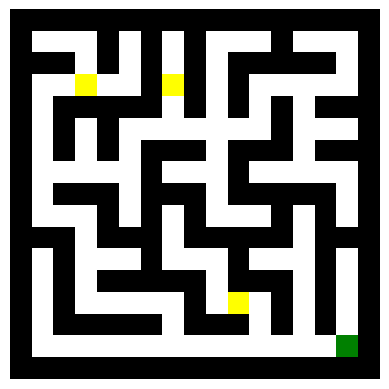

image size: (17, 17)
action size: 4


In [139]:
# Inicialización del entorno
env = MazeEnv((8, 8), False, 3, True, render_mode="rgb-array")
initial = env.reset(False)  # Inicializar el laberinto
plt.imshow(env.render())
plt.axis("off")
plt.show()

H, W = initial.shape[0], initial.shape[1]
img = torch.tensor(initial).reshape(1, 1, H, W).float()

# Definir la red FuN
num_actions = env.action_space.n
img_shape = (H, W)
print('image size:', img_shape)
print('action size:', num_actions)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
horizon = 9

net = FuN(img_shape, num_actions, horizon, device)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.00025, eps=0.01)
writer = SummaryWriter('logs')

net.to(device)
net.train()
global_steps = 0
score = 0
count = 0
grad_norm = 0

# Inicializar histories con el estado inicial del entorno
histories = torch.tensor(initial).reshape(1, 1, H, W).float().to(device)

# Ajustar el tamaño del lote de las memorias LSTM
batch_size = 1
m_hx = torch.zeros(batch_size, num_actions * 16).to(device)
m_cx = torch.zeros(batch_size, num_actions * 16).to(device)
m_lstm = (m_hx, m_cx)

w_hx = torch.zeros(batch_size, num_actions * 16).to(device)
w_cx = torch.zeros(batch_size, num_actions * 16).to(device)
w_lstm = (w_hx, w_cx)

goals_horizon = torch.zeros(batch_size, horizon + 1, num_actions * 16).to(device)


In [141]:
while True:
    count += 1
    memory = Memory()
    global_steps += 1

    # gather samples from the environment
    for i in range(5):
        net_output = net(histories.to(device), m_lstm, w_lstm, goals_horizon)
        policies, goal, goals_horizon, m_lstm, w_lstm, m_value, w_value_ext, w_value_int, m_state = net_output

        actions = torch.multinomial(policies, 1).squeeze().cpu().numpy()

        # send action to the environment and get state information
        next_history, reward, done = env.step(actions)
        next_history = torch.tensor(next_history).reshape(1, 1, H, W).float().to(device)

        score += reward

        # if agent in environment dies, print and log score
        if done: 
            entropy = - policies * torch.log(policies + 1e-5)
            entropy = entropy.mean().data.cpu()
            print('global steps {} | score: {} | entropy: {:.4f} | grad norm: {:.3f} '.format(global_steps, score, entropy, grad_norm))
            writer.add_scalar('log/score', score, global_steps)
            score = 0

        memory.push(histories, next_history, actions, reward, goal, policies, m_lstm, w_lstm, m_value, w_value_ext, w_value_int, m_state)
        histories = next_history

    # Train every 5 steps
    if (global_steps % 5) == 0:
        transitions = memory.sample()
        loss, grad_norm = train_model(net, optimizer, transitions)
        m_hx, m_cx = m_lstm
        m_lstm = (m_hx.detach(), m_cx.detach())
        w_hx, w_cx = w_lstm
        w_lstm = (w_hx.detach(), w_cx.detach())
        goals_horizon = goals_horizon.detach()

    if count % 100 == 0:
        ckpt_path = 'model.pt'
        torch.save(net.state_dict(), ckpt_path)

TypeError: unhashable type: 'numpy.ndarray'